<a href="https://colab.research.google.com/github/nathaliacastelobranco/structural-dynamics/blob/main/nn_composite_floor_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede neural para previsão de aceleração variando a frequência de excitação

A rede está restrita ao piso em que foi treinada, mas pode ser utilizada para prever a resposta dinâmica quando a frequência de excitação for alterada. Esse processo pode ser feito pelo Ansys, porém demanda um esforço computacional maior. Usando a rede neural é possível otimizar a performance de um estudo paramétrico.

Os dados de entrada serão baseados no modelo AISC na seção de maior amplitude modal.
A frequência de excitação inicial será de 2,20Hz, visto que temos os resultados da análise transiente calculados via Ansys.
Com base na função de excitação do modelo AISC para geração do carregamento dinâmico, alteramos essa frequência de excitação e obtemos as novas acelerações. Com esses dados é possível avaliar o conforto humano no piso em estudo.

Os dados de saída serão as acelerações no domínio do tempo dada nova frequência de excitação.

A avaliação dos resultados será feita via correlação de Pearson.

**Dados iniciais**

In [ ]:
# Peso da pessoa (N)
weight = 798.0

# Frequência de excitação (Hz)
freq = 2.2

# Frequência fundamental do piso em estudo (Hz)
FN01 = 5.6

# Intervalo de variação de tempo - steps (s)
DELTA_T = 0.002

# ---------
# Características do AISC

# Número de harmônicos considerados
N_HARMONICS = 3

# Coeficientes dinâmicos
alfa1 = 1.5
alfa2 = 0.6
alfa3 = 0.1

# Ângulos de fase
phi1 = 0
phi2 = 0
phi3 = 0

In [ ]:
# Importando dependências
# ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.__version__

from numpy.random import seed
seed(42)

%matplotlib inline

Função de carregamento dinâmico AISC

$$
F\left ( t \right ) = Q + \sum_{i=1}^{N} \alpha_{i}Qsen\left ( 2\pi if_{step}t-\phi_{i} \right )
$$

In [ ]:
def func_aisc(initial_time, final_time, f_step, person_weight):
    Q = person_weight

    aisc = []
    time = []

    for t in np.arange(initial_time, final_time + DELTA_T, DELTA_T):
        aux1 = alfa1 * Q * np.sin(2 * np.pi * 1 * f_step * t - phi1)
        aux2 = alfa2 * Q * np.sin(2 * np.pi * 2 * f_step * t - phi2)
        aux3 = alfa3 * Q * np.sin(2 * np.pi * 3 * f_step * t - phi3)

        aux_sum = aux1 + aux2 + aux3 + Q

        time.append(t)
        aisc.append(aux_sum)


    data = list(zip(time, aisc))

    dataframe = pd.DataFrame(data, columns=['time', 'aisc'])
    dataframe['freq'] = f_step
    dataframe.set_index('time', inplace=True)

    return dataframe, aisc



In [ ]:
aisc_df, aisc = func_aisc(0, 10, freq, weight)

In [ ]:
aisc_df.reset_index(inplace=True)

In [ ]:
aisc_df.head()

,time,aisc,freq
0,0.000,798.000000,2.2
1,0.002,864.159273,2.2
2,0.004,930.166936,2.2
3,0.006,995.871958,2.2
4,0.008,1061.124462,2.2


In [ ]:
aisc = np.array(aisc)

In [ ]:
np.isnan(aisc).sum()

0

In [ ]:
aisc.max()

2251.894039788374

In [ ]:
aisc.min()

-655.894039788373

In [ ]:
# data_sectionD = pd.read_excel('data_sectionD_LMII_AISC.xlsx', index_col='time')
data_sectionD = pd.read_excel('data_sectionD_LMII_AISC.xlsx')

In [ ]:
data_sectionD.head()

,time,desloc,vel,acel
0,0.000,0.000000,0.000000,0.00000
1,0.002,0.000002,0.002833,1.61970
2,0.004,0.000009,0.005769,1.46797
3,0.006,0.000025,0.008705,1.31624
4,0.008,0.000044,0.011034,1.63116


In [ ]:
data_sectionD.dtypes

time      float64
desloc    float64
vel       float64
acel      float64
dtype: object

In [ ]:
aisc_df.dtypes

time    float64
aisc    float64
freq    float64
dtype: object

In [ ]:
# data = data_sectionD.join(aisc_df, on='time')
# data = pd.concat([data_sectionD, aisc_df])
data = pd.merge(data_sectionD, aisc_df, on="time")

acel - minha variável dependente
aisc - minha variável independente



In [ ]:
data.head()

,time,desloc,vel,acel,aisc,freq
0,0.000,0.000000,0.000000,0.00000,798.000000,2.2
1,0.002,0.000002,0.002833,1.61970,864.159273,2.2
2,0.004,0.000009,0.005769,1.46797,930.166936,2.2
3,0.006,0.000025,0.008705,1.31624,995.871958,2.2
4,0.008,0.000044,0.011034,1.63116,1061.124462,2.2


In [ ]:
# data.reset_index(inplace=True)

In [ ]:
data.isna().sum()

time      0
desloc    0
vel       0
acel      0
aisc      0
freq      0
dtype: int64

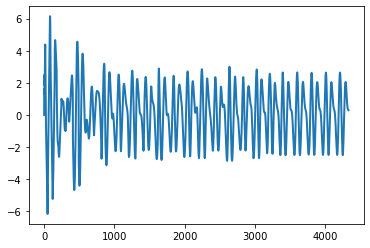

In [ ]:
data['acel'].plot(linewidth=2);

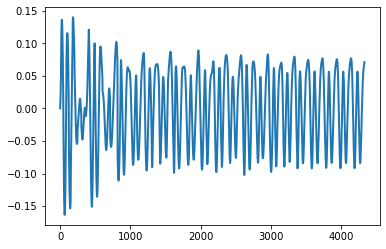

In [ ]:
data['vel'].plot(linewidth=2);

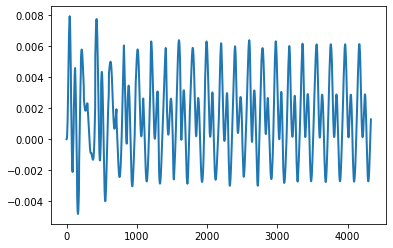

In [ ]:
data['desloc'].plot(linewidth=2);

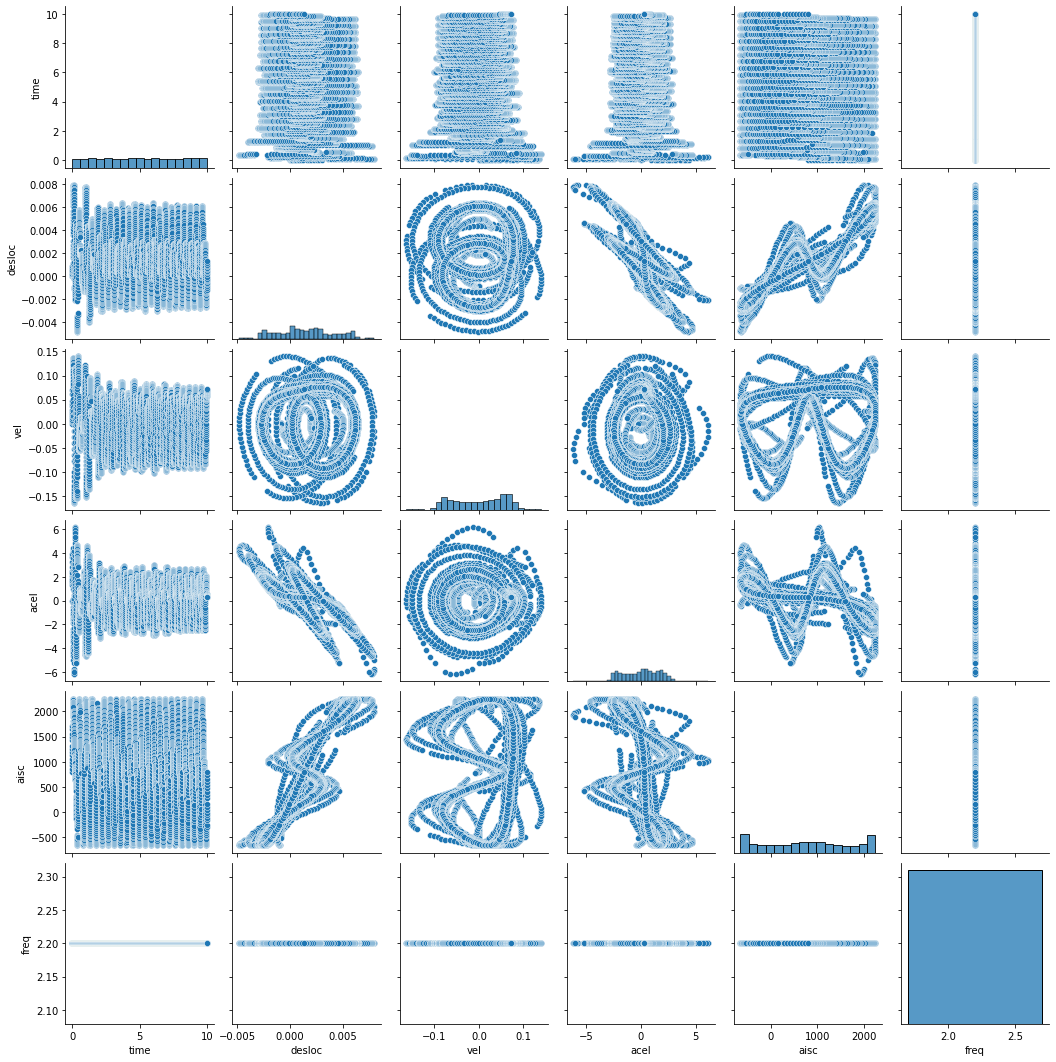

In [ ]:

sns.pairplot(data)

<AxesSubplot:>

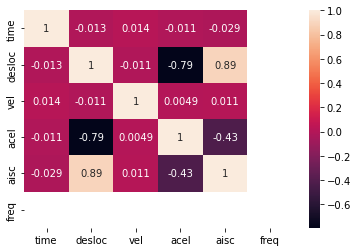

In [ ]:
sns.heatmap(data.corr(), annot=True)

A variável com maior correlação com a função AISC é o deslocamento.

### Separar variáveis dependentes de independentes

In [ ]:
# AISC
x = data.drop(['time','freq','desloc', 'vel','acel'], axis=1).values

In [ ]:
x

array([[798.        ],
       [864.15927308],
       [930.16693607],
       ...,
       [665.83306393],
       [731.84072692],
       [798.        ]])

In [ ]:
print(f'O maior valor da variável independente é {x.max()} e o menor valor é {x.min()}.')

O maior valor da variável independente é 2251.894039788374 e o menor valor é -655.894039788373.


In [ ]:
# DESLOCAMENTO
y = data[['desloc']].values

In [ ]:
print(f'O maior valor da variável dependente é {y.max()} e o menor valor é {y.min()}.')

O maior valor da variável dependente é 0.00793268 e o menor valor é -0.00482267.


In [ ]:
y

array([[0.00000e+00],
       [1.56604e-06],
       [9.22167e-06],
       ...,
       [9.98092e-04],
       [1.13858e-03],
       [1.28026e-03]])

**Normalização das variáveis dependentes**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [ ]:
y

array([[0.37808998],
       [0.37821275],
       [0.37881294],
       ...,
       [0.45633887],
       [0.46735291],
       [0.47846041]])

In [ ]:
x = scaler.fit_transform(x)

In [ ]:
x

array([[798.        ],
       [864.15927308],
       [930.16693607],
       ...,
       [665.83306393],
       [731.84072692],
       [798.        ]])

In [ ]:
print(f'O maior valor da variável independente após a normalização é {x.max()} e o menor valor é {x.min()}.')
print(f'O maior valor da variável dependente após a normalização é {y.max()} e o menor valor é {y.min()}.')

O maior valor da variável independente após a normalização é 1.0 e o menor valor é 0.0.
O maior valor da variável dependente após a normalização é 1.0 e o menor valor é 0.0.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [ ]:
X_train.shape

(3464, 1)

In [ ]:
X_train

array([[0.30895042],
       [0.72590869],
       [0.98690736],
       ...,
       [0.79351793],
       [0.05616054],
       [0.15293012]])

In [ ]:
y_train

array([[0.37790686],
       [0.53536124],
       [0.87845571],
       ...,
       [0.66903378],
       [0.2788869 ],
       [0.26917411]])

In [ ]:
y_train.shape

(3464, 1)

## Regressão Linear por Rede neural

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 2, activation='relu', input_shape=(1,)))
# model.add(tf.keras.layers.Dense(units=100, activation='relu'))
# model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 2)                 4         
                                                                 
 dense_29 (Dense)            (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs_hist = model.fit(X_train, y_train, epochs = 20, batch_size = 50, validation_split=0.2)

Epoch 1/20
56/56 [==============================] - 1s 6ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967 - val_loss: 0.2102 - val_root_mean_squared_error: 0.4585
Epoch 2/20
56/56 [==============================] - 0s 3ms/step - loss: 0.1766 - root_mean_squared_error: 0.4203 - val_loss: 0.1435 - val_root_mean_squared_error: 0.3788
Epoch 3/20
56/56 [==============================] - 0s 3ms/step - loss: 0.1153 - root_mean_squared_error: 0.3395 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2985
Epoch 4/20
56/56 [==============================] - 0s 2ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2288
Epoch 5/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0415 - root_mean_squared_error: 0.2038 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 6/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0251 - val_root_mean_sq

---
**Avaliação do modelo**


In [ ]:
epochs_hist.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

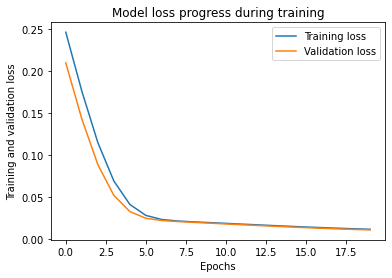

In [ ]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Training loss', 'Validation loss']);

In [ ]:
y_predict = model.predict(X_test)

28/28 [==============================] - 0s 1ms/step


Text(0, 0.5, 'True values')

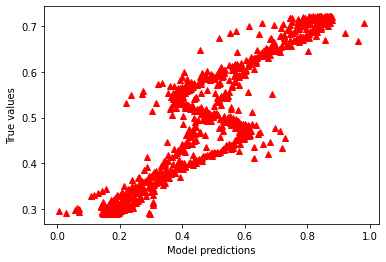

In [ ]:
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model predictions')
plt.ylabel('True values')

In [ ]:
y_predict_orig = scaler.inverse_transform(y_predict)
y_test_orig = scaler.inverse_transform(y_test)

Text(0, 0.5, 'True values')

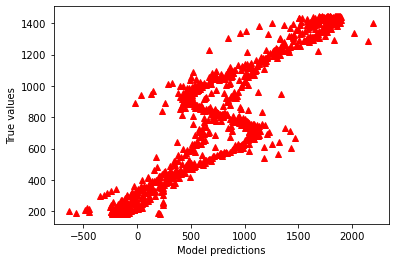

In [ ]:
plt.plot(y_test_orig, y_predict_orig, "^", color = 'r')
plt.xlabel('Model predictions')
plt.ylabel('True values')

In [ ]:
k = X_test.shape[1]
k

1

In [ ]:
n = len(X_test)
n

866

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

In [ ]:
mae = mean_absolute_error(y_test_orig, y_predict_orig)
mse = mean_squared_error(y_test_orig, y_predict_orig)
rmse = sqrt(mse)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [ ]:
print("MAE: ", mae, "\nMSE: ", mse, "\nRMSE: ", rmse, "\nR2: ", r2, "\nADJ R2: ", adj_r2)

MAE:  212.2233915498639 
MSE:  79305.59630325952 
RMSE:  281.61249315905627 
R2:  0.7857805839115266 
ADJ R2:  0.7855326447725353


## Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#definindo o algoritmo utilizado
LinearRegressionModel = LinearRegression()

#treinando o algoritmo com a base de treino
LinearRegressionModel.fit(X_train,y_train)

#criando a predição que será usada na avalização
y_pred = LinearRegressionModel.predict(X_test)

In [ ]:
y_predict_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test)

X_train_orig = scaler.inverse_transform(X_train)
X_test_orig = scaler.inverse_transform(X_test)

In [ ]:
mae = mean_absolute_error(y_test_orig, y_predict_orig)
mse = mean_squared_error(y_test_orig, y_predict_orig)
rmse = sqrt(mse)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [ ]:
print("MAE: ", mae, "\nMSE: ", mse, "\nRMSE: ", rmse, "\nR2: ", r2, "\nADJ R2: ", adj_r2)

MAE:  211.52672790590879 
MSE:  76588.9474604389 
RMSE:  276.74708211729876 
R2:  0.7916261529702973 
ADJ R2:  0.7913849795362351


**Resultados da regressão linear por NN**

MAE:  212.2233915498639
MSE:  79305.59630325952
RMSE:  281.61249315905627
R2:  0.7857805839115266
ADJ R2:  0.7855326447725353


**Resultados da regressão linear padrão**
MAE:  211.52672790590879
MSE:  76588.9474604389
RMSE:  276.74708211729876
R2:  0.7916261529702973
ADJ R2:  0.7913849795362351

## Teste com a nova força dinâmica

In [ ]:
# Variando a frequência de excitação entre 2.0 a 2.5Hz

# 2.0
aisc_df_20, aisc_20 = func_aisc(0, 10, 2.0, weight)

# 2.1
aisc_df_21, aisc_21 = func_aisc(0, 10, 2.1, weight)

# 2.3
aisc_df_23, aisc_23 = func_aisc(0, 10, 2.3, weight)

# 2.4
aisc_df_24, aisc_24 = func_aisc(0, 10, 2.4, weight)

# 2.5
aisc_df_25, aisc_25 = func_aisc(0, 10, 2.5, weight)

In [ ]:
len(aisc_20)

5001

In [ ]:
# Deslocamentos para novas frequências (NN)
x_aisc_20 = np.array(aisc_20).reshape(-1,1)
x_aisc_20 = scaler.fit_transform(x_aisc_20)
y_pred_NN_20 = model.predict(x_aisc_20)
y_pred_NN_20_orig = scaler.inverse_transform(y_pred_NN_20)

print(f'Os deslocamentos previstos pela NN são {y_pred_NN_20_orig}.')

157/157 [==============================] - 0s 1ms/step
Os deslocamentos previstos são [[813.97314]
 [840.05084]
 [866.079  ]
 ...
 [761.8673 ]
 [787.8956 ]
 [813.97314]].


In [ ]:
# Deslocamentos para novas frequências (LR)
y_pred_LR_20 = LinearRegressionModel.predict(x_aisc_20)
y_pred_LR_20_orig = scaler.inverse_transform(y_pred_LR_20)

print(f'Os deslocamentos previstos pela LR são {y_pred_LR_20_orig}.')

Os deslocamentos previstos pela LR são [[788.9605283 ]
 [824.45024821]
 [859.87274822]
 ...
 [718.04830838]
 [753.47080839]
 [788.9605283 ]].


In [ ]:
time = data_sectionD['time'].values
time

array([0.000e+00, 2.000e-03, 4.000e-03, ..., 9.996e+00, 9.998e+00,
       1.000e+01])

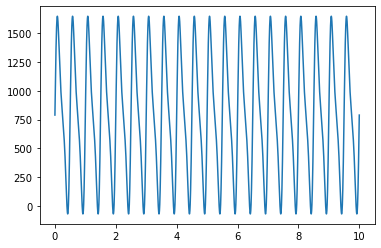

In [ ]:
plt.plot(time, y_pred_LR_20_orig);

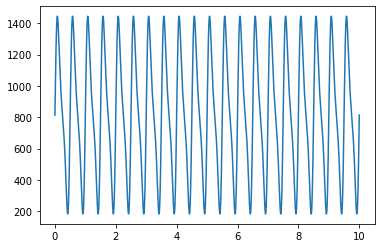

In [ ]:
plt.plot(time, y_pred_NN_20_orig);